In [1]:
using PyCall
itikz=pyimport("itikz")
jinja=pyimport("jinja2");

# Example

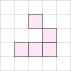

In [2]:
src=raw"\documentclass[tikz]{standalone}

       \begin{document}
       \begin{tikzpicture}[scale=0.5]
       \draw[help lines] grid (5, 5);
       \draw[fill=magenta!10] (1, 1) rectangle (2, 2);
       \draw[fill=magenta!10] (2, 1) rectangle (3, 2);
       \draw[fill=magenta!10] (3, 1) rectangle (4, 2);
       \draw[fill=magenta!10] (3, 2) rectangle (4, 3);
       \draw[fill=magenta!10] (2, 3) rectangle (3, 4);

       \end{tikzpicture}
       \end{document}"

itikz.fetch_or_compile_svg(src,"", "/tmp", false, false )

# Main Functions

The toolchain tex_command -> svg_converter -> crop_program
succeeds or fails depending on tex engine, documentclass and packages.

To set up the toolchain, run

In [3]:
?itikz.build_commands


build_commands( tex_program=["pdflatex"], svg_converter=[["pdf2svg"],".pdf"], use_xetex=False, use_dvi=False, crop=False, nexec=1):
    

Use the output of build_commands to invoke the toolchain on a tex document string

In [4]:
?itikz.fetch_or_compile_svg


fetch_or_compile_svg(src, prefix='', working_dir=None, full_err=False, debug=False, tex_program=["pdflatex"], svg_converter=[["pdf2svg"],".pdf"], svg_crop=None, nexec=1):
    

# Commutative Diagram Example

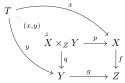

In [5]:
src = raw"""
\documentclass[tikz]{standalone}
\usepackage{tikz-cd}
\usetikzlibrary{cd}

\begin{document}
\begin{tikzcd}
T
\arrow[drr, bend left, "x"]
\arrow[ddr, bend right, "y"]
\arrow[dr, dotted, "{(x,y)}" description] & & \\
& X \times_Z Y \arrow[r, "p"] \arrow[d, "q"]
& X \arrow[d, "f"] \\
& Y \arrow[r, "g"]
& Z
\end{tikzcd}
\end{document}
"""
itikz.fetch_or_compile_svg(src,"", "/tmp", false, false )